# Practical 6: Cell-Cell Communication

Author: Francesca Drummer

In this notebook we will cover different methods to revocer cell-cell communication (CCC) in spatial transcriptomics. 

1. non-spatial CCC testing with spatial DE genes or post-processing filter (e.i. spatial distance) using CellPhoneDB
2. MISTy

To reduce the environment dependencies we will use the LIANA+ implementation of the methods. 
Please notice that the original tools might offer more functionalities. 
For that reason we will always link to the original publication and GitHub repository.

In [50]:
import squidpy as sq
import scanpy as sc

from pathlib import Path
import numpy as np

from scipy.sparse import issparse, csr_matrix

from liana.method import singlecellsignalr, connectome, cellphonedb, natmi, logfc, cellchat, geometric_mean

## 0. Download data

We will use the **Xenium AD dataset** from the previous notebooks here.

As a reminder the dataset consists of 6 coronal mouse brain slices from 2 different conditions (wildtype - ctrl vs TgCRND8 - AD) across 3 timepoints. In this practical, we additionally have information about cell types available in  `adata.obs['cell_types']`. Please note that these annotation are not perfect. For example, there are quite some cells that could not be assigned to a cell type (NaN or "unkown"). These annotations have been made with on leiden clustering and marker genes reported in [this](https://pages.10xgenomics.com/rs/446-PBO-704/images/10x_LIT000210_App-Note_Xenium-In-Situ_Letter_Digital.pdf) document. 

In this practical we aim to understand the differences of the mouse brain between the two conditions and across the timepoints using niches and spatial domains.

In [66]:
PATH = "/Users/francesca.drummer/Documents/1_Projects/ELIXIR_2025/Xenium_mouse_AD/anndata/"

In [67]:
# load adata
adata = sc.read_h5ad(Path(PATH, 'xenium_mouse_ad_annotated_rotated.h5ad'))
adata

AnnData object with n_obs × n_vars = 350209 × 347
    obs: 'cell_id', 'transcript_counts', 'control_probe_counts', 'control_codeword_counts', 'unassigned_codeword_counts', 'total_counts', 'cell_area', 'nucleus_area', 'region', 'cell_labels', 'condition', 'time', 'batch_key', 'leiden_res0_25', 'leiden_res0_5', 'leiden_res1', 'cell_types', 'sample'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'cell_types_colors', 'dea_leiden_res0_25', 'dendrogram_leiden_res0_25', 'leiden', 'leiden_res0_25_colors', 'leiden_res0_5_colors', 'leiden_res1_colors', 'neighbors', 'umap'
    obsm: 'X_pca', 'X_umap', 'spatial'
    obsp: 'connectivities', 'distances'

In [68]:
print(adata.X[:2,:2])

<Compressed Sparse Row sparse matrix of dtype 'float32'
	with 1 stored elements and shape (2, 2)>
  Coords	Values
  (1, 0)	1.0


In [69]:
adata.layers['counts'] = adata.X

In [70]:
# Normalization to the median
sc.pp.normalize_total(adata)

# Freeman-Tukey square root transform
assert issparse(adata.X)
sqrt_X = adata.X.sqrt()
# Create a new sparse matrix for X + 1
X_plus_1 = adata.X + csr_matrix(np.ones(adata.X.shape))
# Calculate the square root of (X + 1)
sqrt_X_plus_1 = X_plus_1.sqrt()
adata.layers['median_ft'] = sqrt_X + sqrt_X_plus_1

## 0. Introduction to LIANA+

[LIANA+](https://liana-py.readthedocs.io/en/latest/notebooks/basic_usage.html) is a toolbox in Python for various dissociated, multimodal and spatially informed cell-cell communication tools [Dimitrov et al., 2024]. 

First we install the package and observe which methods are implemented in LIANA+. 
Each method relies on different assumptions and returns a different ligand-receptor score. 
Usually, one score for the strength of the interaction (`magnitude`) and a score reflecting the `specifivity` of a interaction to a pair of cell identities. 

In [71]:
import liana as li

li.mt.show_methods()

,Method Name,Magnitude Score,Specificity Score,Reference
0,CellPhoneDB,lr_means,cellphone_pvals,"Efremova, M., Vento-Tormo, M., Teichmann, S.A...."
0,Connectome,expr_prod,scaled_weight,"Raredon, M.S.B., Yang, J., Garritano, J., Wang..."
0,log2FC,None,lr_logfc,"Dimitrov, D., Türei, D., Garrido-Rodriguez, M...."
0,NATMI,expr_prod,spec_weight,"Hou, R., Denisenko, E., Ong, H.T., Ramilowski,..."
0,SingleCellSignalR,lrscore,None,"Cabello-Aguilar, S., Alame, M., Kon-Sun-Tack, ..."
0,Rank_Aggregate,magnitude_rank,specificity_rank,"Dimitrov, D., Türei, D., Garrido-Rodriguez, M...."
0,Geometric Mean,lr_gmeans,gmean_pvals,CellPhoneDBv2's permutation approach applied t...
0,scSeqComm,inter_score,None,"Baruzzo, G., Cesaro, G., Di Camillo, B. 2022. ..."
0,CellChat,lr_probs,cellchat_pvals,"Jin, S., Guerrero-Juarez, C.F., Zhang, L., Cha..."


Most CCC tools identify LR interaction. For this they rely on a extracting LR pairs from databases. There are diverse databases but LIANA+ has a consensus database that uses LR that are overlapping across databases. 

First, we need to ensure that there are LR-pairs present in the data to be detected for communication.

In [72]:
print(li.resource.show_resources())
resource_name = "mouseconsensus"  # Replace with the desired resource name if needed
lr_pairs = li.resource.select_resource(resource_name)
lr_pairs

['baccin2019', 'cellcall', 'cellchatdb', 'cellinker', 'cellphonedb', 'celltalkdb', 'connectomedb2020', 'consensus', 'embrace', 'guide2pharma', 'hpmr', 'icellnet', 'italk', 'kirouac2010', 'lrdb', 'mouseconsensus', 'ramilowski2015']


,ligand,receptor
31371,Dll1,Notch1
31372,Dll1,Notch2
31373,Dll1,Notch4
31374,Dll1,Notch3
31375,Nrg2,Erbb2_Erbb3
...,...,...
35355,Serpina1a,Lrp1
35356,Serpina1b,Lrp1
35357,Serpina1c,Lrp1
35358,Serpina1d,Lrp1


In [73]:
def lr_pairs_in_adata(adata):
    genes_in_dataset = set(adata.var_names)  # Replace `adata.var_names` with your dataset's gene names if different
    
    # Filter the ligand-receptor pairs for those present in your dataset
    filtered_lr_pairs = lr_pairs[
        lr_pairs['ligand'].isin(genes_in_dataset) & lr_pairs['receptor'].isin(genes_in_dataset)
    ]
    
    return filtered_lr_pairs
    

In [74]:
filtered_lr_pairs = lr_pairs_in_adata(adata)

<span style="color:red; font-weight:bold">Task 1: How many ligand-receptor pairs are in the data?</span>

In [75]:
# Count the number of ligand-receptor pairs present in your dataset
num_lr_pairs = len(filtered_lr_pairs)

# Display the count
print(f"Number of ligand-receptor pairs present in the dataset: {num_lr_pairs}")

Number of ligand-receptor pairs present in the dataset: 16


In [76]:
filtered_lr_pairs

,ligand,receptor
31905,Col1a1,Cd44
31912,Col1a1,Cd93
31950,Fn1,Cd44
32039,Col6a1,Cd44
32826,Apoe,Trem2
33084,Spp1,Cd44
33188,Vcan,Cd44
33387,Nts,Ntsr2
33726,Sema3a,Nrp2
34406,Apoe,Sorl1


In the following chapter, we will work with the CellPhoneDB method from LIANA+.

## 1. CellPhoneDB: non-spatial CCC

First, we will run CellPhoneDB as if we did not have any spatial information. 

In [77]:
sub_adata = adata[(adata.obs['time'] == '5_7') & (adata.obs['condition'] == 'TgCRND8')]
sub_adata

View of AnnData object with n_obs × n_vars = 58681 × 347
    obs: 'cell_id', 'transcript_counts', 'control_probe_counts', 'control_codeword_counts', 'unassigned_codeword_counts', 'total_counts', 'cell_area', 'nucleus_area', 'region', 'cell_labels', 'condition', 'time', 'batch_key', 'leiden_res0_25', 'leiden_res0_5', 'leiden_res1', 'cell_types', 'sample'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'cell_types_colors', 'dea_leiden_res0_25', 'dendrogram_leiden_res0_25', 'leiden', 'leiden_res0_25_colors', 'leiden_res0_5_colors', 'leiden_res1_colors', 'neighbors', 'umap'
    obsm: 'X_pca', 'X_umap', 'spatial'
    layers: 'counts', 'median_ft'
    obsp: 'connectivities', 'distances'

In [78]:
cellphonedb(sub_adata,
            groupby='cell_types',
            # NOTE by default the resource uses HUMAN gene symbols
            resource_name='mouseconsensus',
            expr_prop=0.1,
            verbose=True, 
            use_raw = False,
            layer = 'counts',
            key_added='cpdb_res')

Using resource `mouseconsensus`.
Using the `counts` layer!
/Users/francesca.drummer/miniconda3/envs/p6_ccc/lib/python3.11/site-packages/anndata/_core/anndata.py:430: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
/Users/francesca.drummer/miniconda3/envs/p6_ccc/lib/python3.11/site-packages/liana/method/_pipe_utils/_pre.py:153: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
0.94 of entities in the resource are missing from the data.


Generating ligand-receptor stats for 58681 samples and 22 features


100%|██████████| 1000/1000 [00:03<00:00, 253.48it/s]
/Users/francesca.drummer/miniconda3/envs/p6_ccc/lib/python3.11/site-packages/liana/method/sc/_Method.py:266: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.


In [79]:
sub_adata.uns['cpdb_res'].head()

,ligand,ligand_complex,ligand_means,ligand_props,receptor,receptor_complex,receptor_means,receptor_props,source,target,lr_means,cellphone_pvals
18,Apoe,Apoe,13.592422,0.999126,Sorl1,Sorl1,2.806489,0.830238,Astrocytes,Excitatory neurons,8.199455,0.0
42,Apoe,Apoe,13.592422,0.999126,Trem2,Trem2,1.608136,0.666484,Astrocytes,Microglia,7.600279,0.0
30,Apoe,Apoe,13.592422,0.999126,Sorl1,Sorl1,1.550732,0.761789,Astrocytes,Inhibitory neurons,7.571578,0.0
0,Apoe,Apoe,13.592422,0.999126,Sorl1,Sorl1,0.938511,0.528414,Astrocytes,Astrocytes,7.265467,0.0
60,Apoe,Apoe,13.592422,0.999126,Sorl1,Sorl1,0.722670,0.390274,Astrocytes,OPC,7.157546,0.0


<div style="border: 1px solid #0000ff; padding: 10px; border-radius: 5px;">
<span style="color: #0000ff; font-size: 20px;"><b>Interpretation</b></span> <span style="font-size: 20px;">Liana+ scores</span>  

<span></span>
<ul>
    <li>source and target columns represent the source/sender and target/receiver cell identity for each interaction, respectively</li>
    <li>*_props: represents the proportion of cells that express the entity.</li>
    <li>*_means: entity expression mean per cell type.</li>
    <li>lr_means: mean ligand-receptor expression, as a measure of ligand-receptor interaction magnitude</li>
</ul>

<span style="color:red; font-weight:bold">Task 2: Plot the top 3 interacting complexes</span>

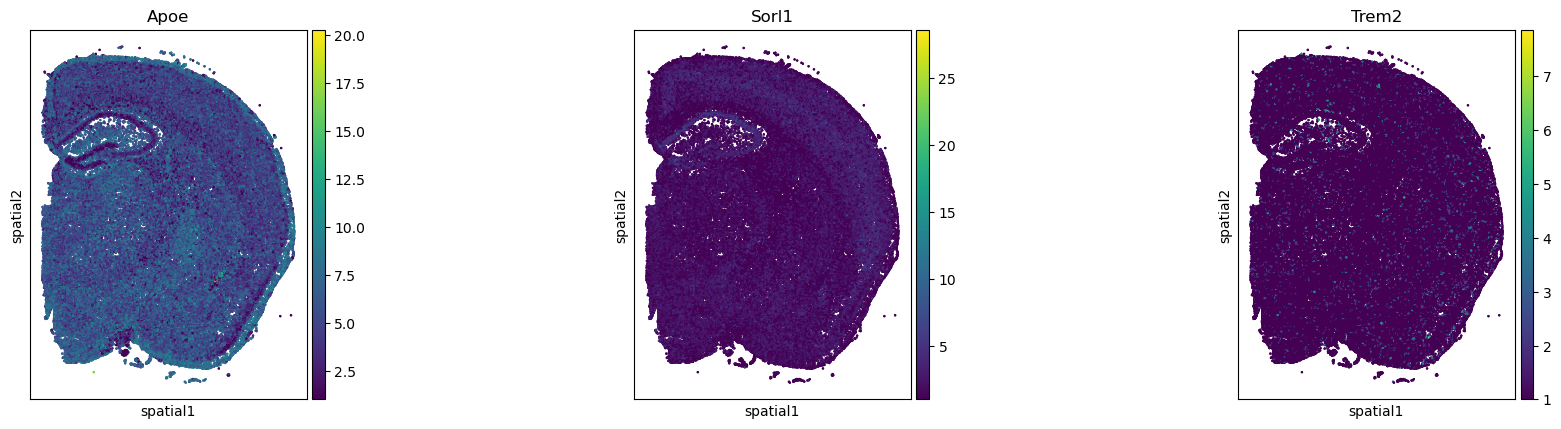

In [80]:
sq.pl.spatial_scatter(sub_adata, 
                      color=["Apoe", "Sorl1", "Trem2"],
                      layer = 'median_ft',
                     shape=None)

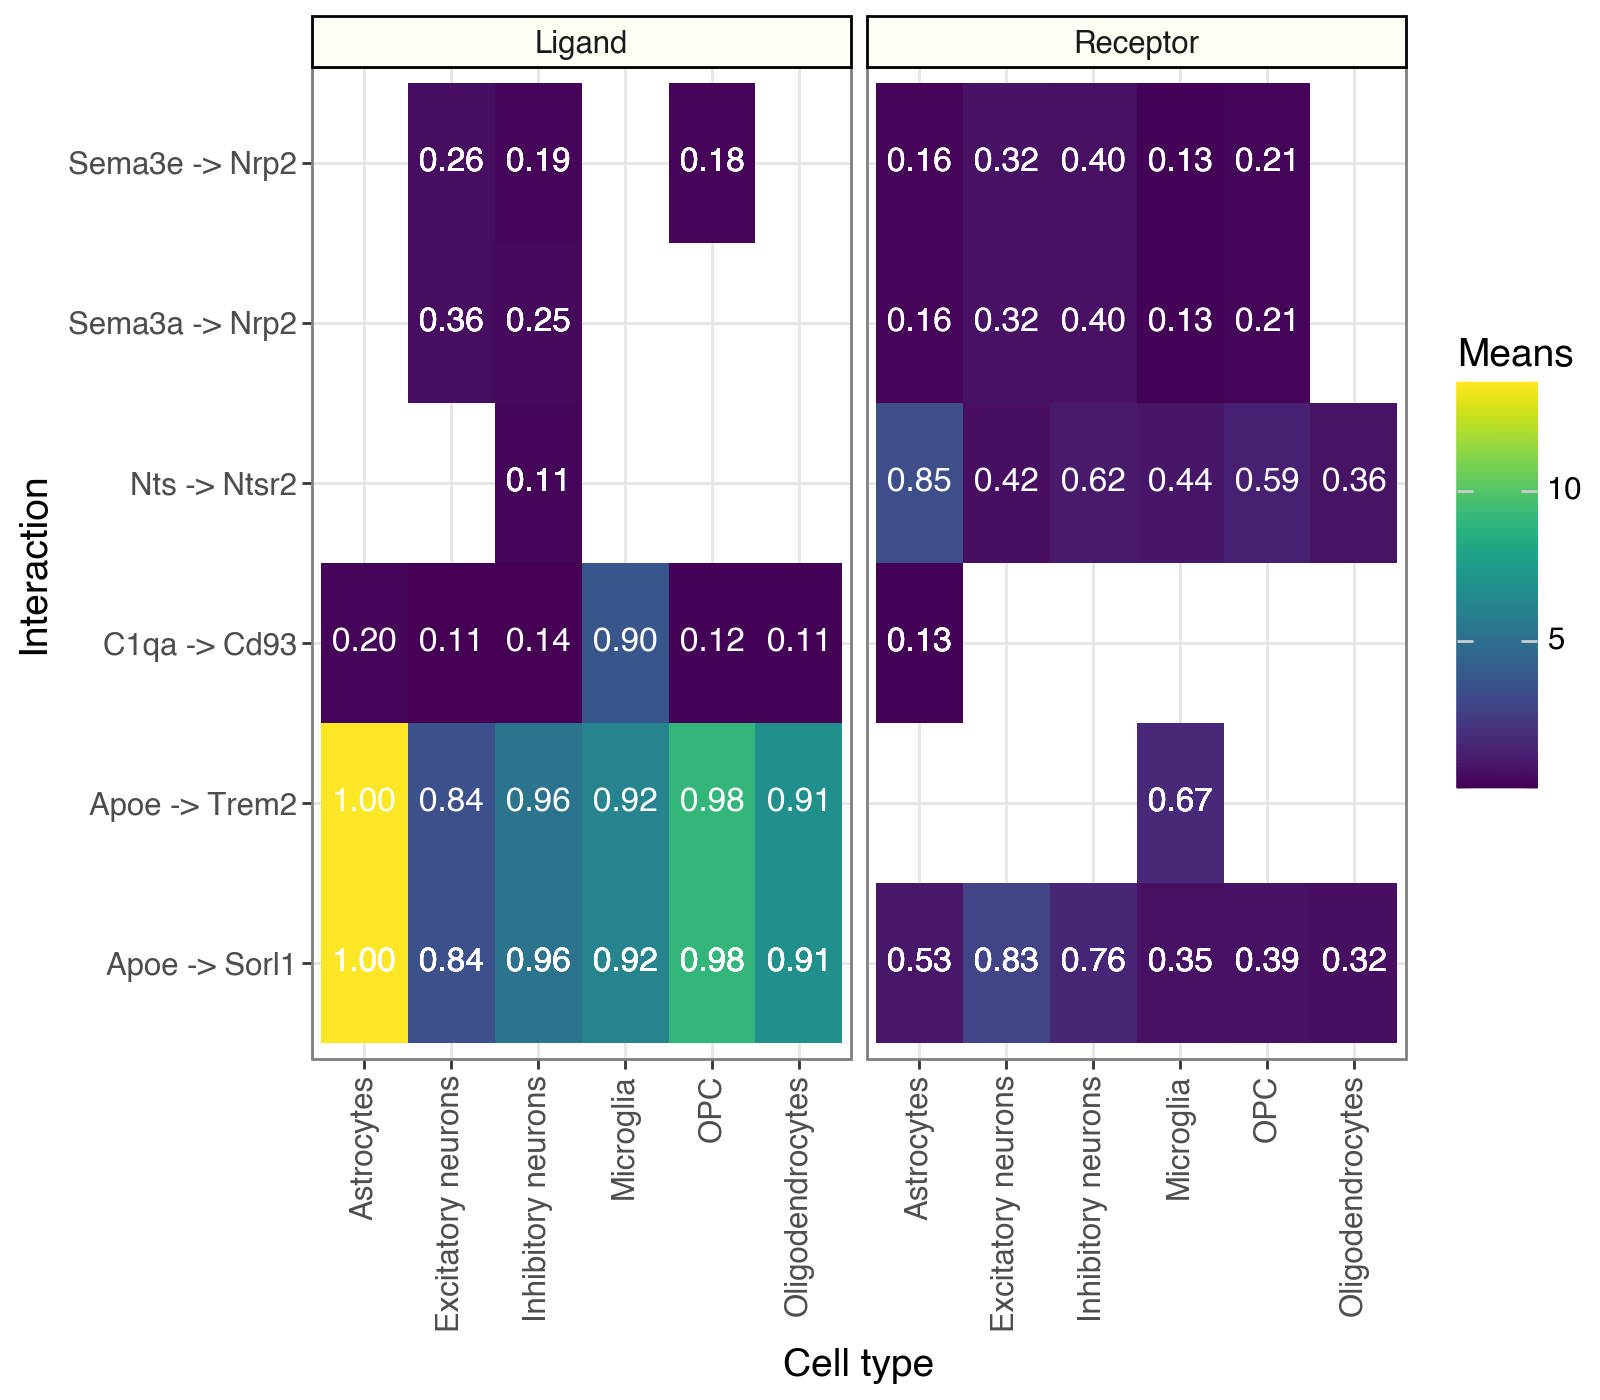

In [81]:
my_plot = li.pl.tileplot(adata = sub_adata,
                         fill='means',
                         label='props',
                         label_fun=lambda x: f'{x:.2f}',
                         top_n=30,
                         orderby='cellphone_pvals',
                         orderby_ascending=True,
                         source_labels=['Astrocytes', 'Excitatory neurons', 'Inhibitory neurons', 'Microglia', 'OPC', 'Oligodendrocytes'],
                         target_labels=['Astrocytes', 'Excitatory neurons', 'Inhibitory neurons', 'Microglia', 'OPC', 'Oligodendrocytes'],
                         uns_key='cpdb_res', # NOTE: default is 'liana_res'
                         source_title='Ligand',
                         target_title='Receptor',
                         figure_size=(8, 7)
                         )
my_plot

<span style="color:red; font-weight:bold">Question: What can we observe if we do not consider spatial information? Why could this be problematic?</span>

To overcome this issue we will cover two possible appraoches to integrate spatial information into non-spatially aware CCC tools, like `CellPhoneDB`.

1. Restrict the input to spatially variable genes. 
2. Post-processing of interactions using spatial proximity, e.i. niche information. 

### Spatially-variable gene selection

We use Moran's I score as a measure of spatial autocorrelation to identify spatially variable genes. 

For more information see: [Chapter 29: Spatially variable genes](https://www.sc-best-practices.org/spatial/spatially_variable_genes.html) from single-cell best practices.

1. Calculate a spatial graph (`sq.gr.spatial_neighbors`)
2. Calculate autocorrelation with [Morans I score](https://squidpy.readthedocs.io/en/stable/notebooks/examples/graph/compute_moran.html) (`sq.gr.spatial_autocorr`)

In [82]:
print(sub_adata.X[:5,:5])

<Compressed Sparse Row sparse matrix of dtype 'float32'
	with 6 stored elements and shape (5, 5)>
  Coords	Values
  (0, 2)	4.50828742980957
  (1, 0)	2.0816328525543213
  (1, 2)	2.0816328525543213
  (2, 2)	2.6322579383850098
  (4, 0)	1.2289156913757324
  (4, 2)	2.457831382751465


In [85]:
sq.gr.spatial_neighbors(sub_adata, n_neighs=30, coord_type="generic", key_added = 'neighs_based_spatial')


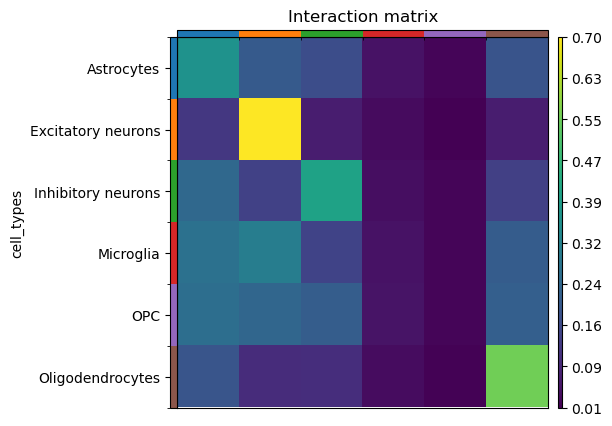

In [88]:
sq.gr.interaction_matrix(sub_adata, cluster_key="cell_types", connectivity_key = 'neighs_based_spatial', normalized=True)
sq.pl.interaction_matrix(sub_adata, cluster_key="cell_types")

In [89]:
sq.gr.spatial_autocorr(sub_adata, connectivity_key = "neighs_based_spatial_connectivities", mode="moran", n_perms=50, genes=sub_adata.var_names)

  0%|          | 0/50 [00:00<?, ?/s]/Users/francesca.drummer/miniconda3/envs/p6_ccc/lib/python3.11/site-packages/dask/dataframe/__init__.py:31: FutureWarning: The legacy Dask DataFrame implementation is deprecated and will be removed in a future version. Set the configuration option `dataframe.query-planning` to `True` or None to enable the new Dask Dataframe implementation and silence this warning.
  warnings.warn(
/Users/francesca.drummer/miniconda3/envs/p6_ccc/lib/python3.11/site-packages/numba/core/decorators.py:246: RuntimeWarning: nopython is set for njit and is ignored
  warnings.warn('nopython is set for njit and is ignored', RuntimeWarning)
100%|██████████| 50/50 [00:29<00:00,  1.68/s]


Show and plot the top genes according to Moran's I score autocorrelation.

In [90]:
sub_adata.uns["moranI"].head()

,I,pval_norm,var_norm,pval_z_sim,pval_sim,var_sim,pval_norm_fdr_bh,pval_z_sim_fdr_bh,pval_sim_fdr_bh
Nwd2,0.637334,0.0,0.000001,0.0,0.019608,0.000009,0.0,0.0,0.019779
Ppp1r1b,0.602092,0.0,0.000001,0.0,0.019608,0.000011,0.0,0.0,0.019779
Mbp,0.592759,0.0,0.000001,0.0,0.019608,0.000008,0.0,0.0,0.019779
Slc17a7,0.575611,0.0,0.000001,0.0,0.019608,0.000011,0.0,0.0,0.019779
Neurod6,0.573918,0.0,0.000001,0.0,0.019608,0.000009,0.0,0.0,0.019779


<div style="border: 1px solid #0000ff; padding: 10px; border-radius: 5px;">
<span style="color: #0000ff; font-size: 20px;"><b>Moran's I score</b></span> <span style="font-size: 20px;"></span>  

<span></span>
<ul>
    <li>I so the Moran’s I,</li>
    <li>pval_norm a p-value under normality assumption.</li>
    <li>var_norm the variance of the Moran’s I under normality assumption.</li>
    <li>{p_val}_{corr_method} the corrected p-values.</li>
</ul>

<span style="color:red; font-weight:bold">Task 3: Plot the 3 genes with the highest I score.</span>

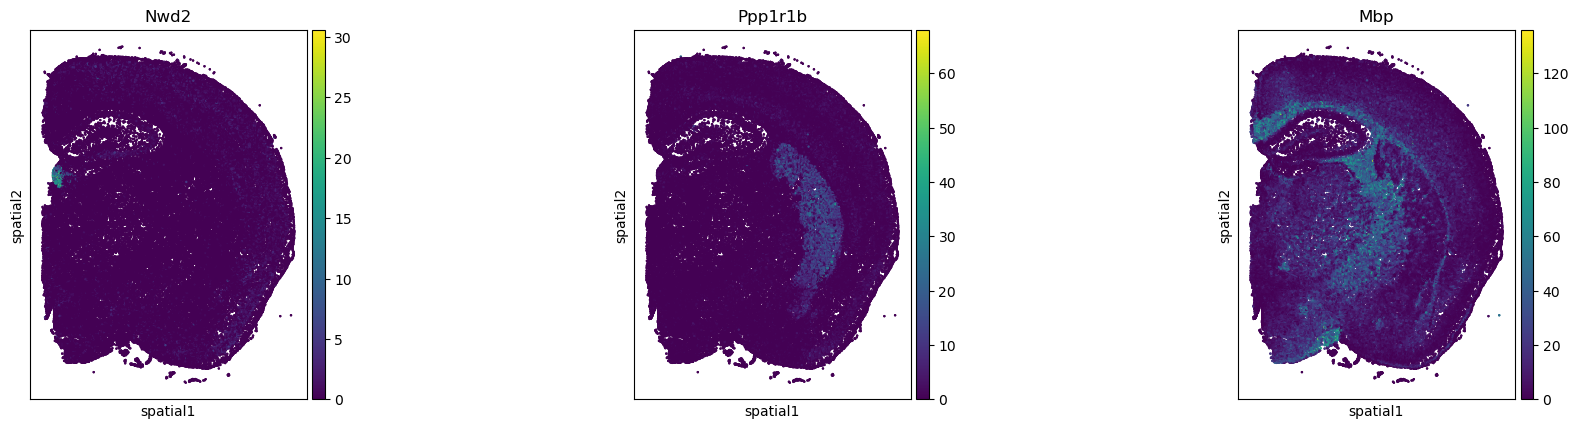

In [93]:
sq.pl.spatial_scatter(sub_adata, 
                      color=["Nwd2", "Ppp1r1b", "Mbp"],
                     shape=None)

<span style="color:red; font-weight:bold">Task 4: Subset the data to include only genes that have a Morans I score higher than 0,2 and check that there are still relevant ligand-receptor pairs in the subdata.</span>

In [94]:
# SOLUTION
sub_adata_svg = sub_adata[:, sub_adata.uns["moranI"]['I'] > 0.2]
sub_adata_svg

View of AnnData object with n_obs × n_vars = 58681 × 115
    obs: 'cell_id', 'transcript_counts', 'control_probe_counts', 'control_codeword_counts', 'unassigned_codeword_counts', 'total_counts', 'cell_area', 'nucleus_area', 'region', 'cell_labels', 'condition', 'time', 'batch_key', 'leiden_res0_25', 'leiden_res0_5', 'leiden_res1', 'cell_types', 'sample'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'cell_types_colors', 'dea_leiden_res0_25', 'dendrogram_leiden_res0_25', 'leiden', 'leiden_res0_25_colors', 'leiden_res0_5_colors', 'leiden_res1_colors', 'neighbors', 'umap', 'cpdb_res', 'neighs_based_spatial_neighbors', 'cell_types_interactions', 'moranI'
    obsm: 'X_pca', 'X_umap', 'spatial'
    layers: 'counts', 'median_ft'
    obsp: 'connectivities', 'distances', 'neighs_based_spatial_connectivities', 'neighs_based_spatial_distances'

In [95]:
# SOLUTION
lr_pairs_in_adata(sub_adata_svg)

,ligand,receptor
31905,Col1a1,Cd44
31912,Col1a1,Cd93
31950,Fn1,Cd44
32039,Col6a1,Cd44
34567,C1qa,Cd93


#### CellPhoneDB

In [96]:
cellphonedb(sub_adata_svg,
            groupby='cell_types',
            # NOTE by default the resource uses HUMAN gene symbols
            resource_name='mouseconsensus',
            expr_prop=0.1,
            verbose=True, 
            use_raw = False,
            layer = 'counts',
            key_added='cpdb_res')

Using resource `mouseconsensus`.
Using the `counts` layer!
/Users/francesca.drummer/miniconda3/envs/p6_ccc/lib/python3.11/site-packages/anndata/_core/anndata.py:430: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
39 samples of mat are empty, they will be removed.
/Users/francesca.drummer/miniconda3/envs/p6_ccc/lib/python3.11/site-packages/liana/method/_pipe_utils/_pre.py:153: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
0.98 of entities in the resource are missing from the data.


Generating ligand-receptor stats for 58681 samples and 6 features


100%|██████████| 1000/1000 [00:02<00:00, 351.66it/s]
/Users/francesca.drummer/miniconda3/envs/p6_ccc/lib/python3.11/site-packages/liana/method/sc/_Method.py:266: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.


In [97]:
sub_adata_svg.uns['cpdb_res'].head()

,ligand,ligand_complex,ligand_means,ligand_props,receptor,receptor_complex,receptor_means,receptor_props,source,target,lr_means,cellphone_pvals
3,C1qa,C1qa,3.718225,0.903226,Cd93,Cd93,0.207941,0.12677,Microglia,Astrocytes,1.963083,0.000
0,C1qa,C1qa,0.311218,0.202483,Cd93,Cd93,0.207941,0.12677,Astrocytes,Astrocytes,0.259579,0.000
5,C1qa,C1qa,0.194758,0.112398,Cd93,Cd93,0.207941,0.12677,Oligodendrocytes,Astrocytes,0.201350,0.645
4,C1qa,C1qa,0.183544,0.124688,Cd93,Cd93,0.207941,0.12677,OPC,Astrocytes,0.195742,0.657
2,C1qa,C1qa,0.139770,0.135632,Cd93,Cd93,0.207941,0.12677,Inhibitory neurons,Astrocytes,0.173855,1.000


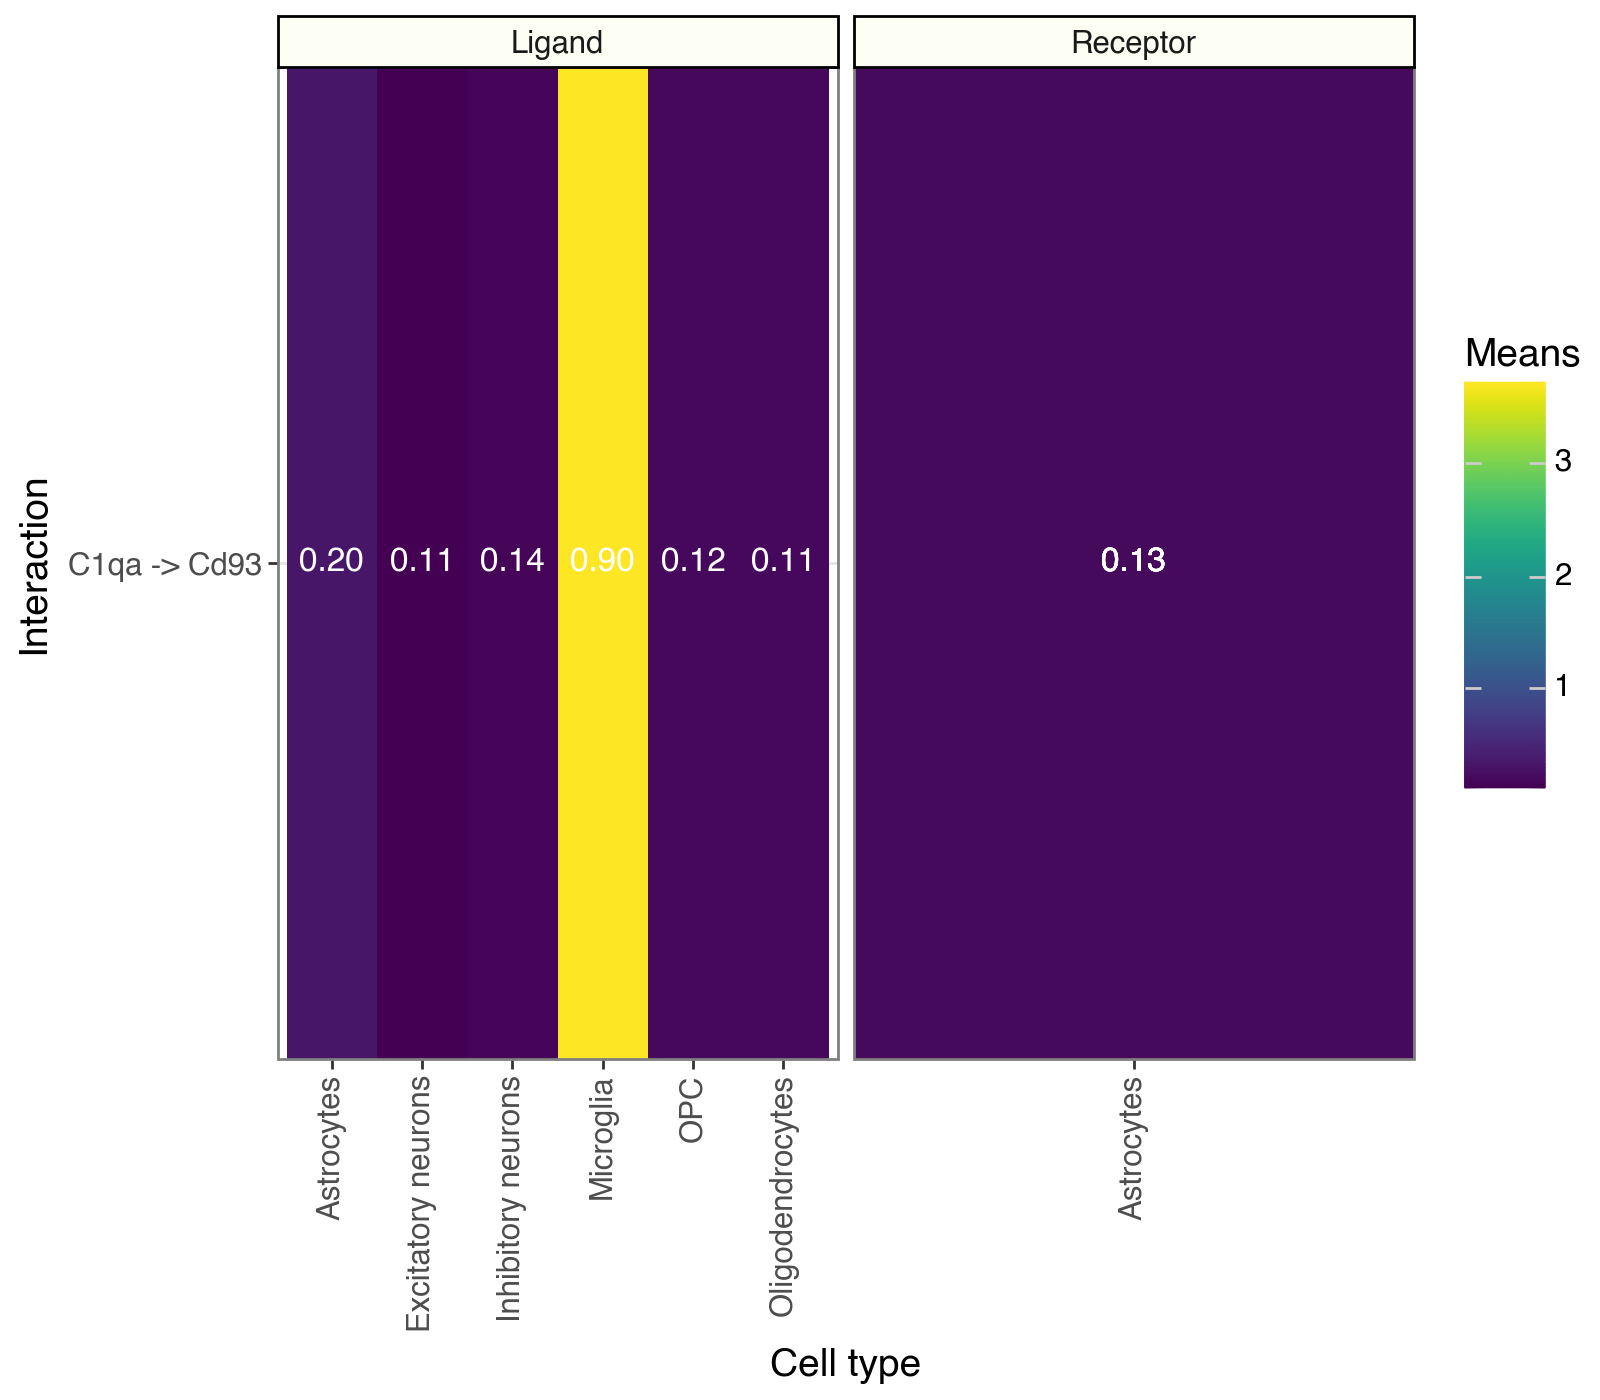

In [98]:
my_plot = li.pl.tileplot(adata = sub_adata_svg,
                         fill='means',
                         label='props',
                         label_fun=lambda x: f'{x:.2f}',
                         top_n=20,
                         orderby='cellphone_pvals',
                         orderby_ascending=True,
                         source_labels=['Astrocytes', 'Excitatory neurons', 'Inhibitory neurons', 'Microglia', 'OPC', 'Oligodendrocytes'],
                         target_labels=['Astrocytes'],
                         uns_key='cpdb_res', # NOTE: default is 'liana_res'
                         source_title='Ligand',
                         target_title='Receptor',
                         figure_size=(8, 7)
                         )
my_plot

<span style="color:red; font-weight:bold">Question: What could be a potential limitation / problem with this approach?</span>

<span style="color:red; font-weight:bold">Optional Task: Compare the results for the healthy control or different time points. Do the CCC across cell types change?.</span>

<span style="color:red; font-weight:bold">Optional Task: Change the `expr_prop` in the CellPhoneDB function and try out some other tools like CellChat. How does it effect the results?.</span>

### Spatial proximity

An alternative to pre-selecting spatially variable genes is by restricting the cells to be spatially close when they are communicating. For this we will be using the calculated spatial domains from the previous tutorial. 

In [ ]:
sq.pl.spatial_scatter(sub_adata,
                      color = ['cell_types', 'spatial_domain_temp'],
                      shape=None)

<span style="color:red; font-weight:bold">Task 5: Choose a spatial domain cluster that contains a high proportion of the cell types you are interested in to understand the interaction. Tip: also check that the fraction of unkwon cells is low. </span>

In [ ]:
def relative_abundances(adata, group_by, cell_type_key):
    counts = adata.obs.groupby([group_by, cell_type_key]).size().unstack(fill_value=0)
    relative_abundance = counts.div(counts.sum(axis=1), axis=0)
    return relative_abundance

In [ ]:
relative_abundances(sub_adata, group_by='spatial_domain_temp', cell_type_key='cell_types')

In [ ]:
## SOLUTION
domain = 15

In [ ]:
sub_adata_domain = sub_adata[sub_adata.obs['spatial_domain_temp'] == domain]
sub_adata_domain

In [ ]:
cellphonedb(sub_adata_domain,
            groupby='cell_types',
            # NOTE by default the resource uses HUMAN gene symbols
            resource_name='mouseconsensus',
            expr_prop=0.1,
            verbose=True, 
            use_raw = False,
            layer = 'counts',
            key_added='cpdb_res')

In [ ]:
sub_adata_domain.uns['cpdb_res'].head()

In [ ]:
my_plot = li.pl.tileplot(adata = sub_adata_domain,
                         fill='means',
                         label='props',
                         label_fun=lambda x: f'{x:.2f}',
                         top_n=20,
                         orderby='cellphone_pvals',
                         orderby_ascending=True,
                         source_labels=['Astrocytes', 'Excitatory neurons', 'Inhibitory neurons', 'Microglia', 'OPC', 'Oligodendrocytes'],
                         target_labels=['Astrocytes', 'Excitatory neurons', 'Inhibitory neurons', 'Microglia', 'OPC', 'Oligodendrocytes'],
                         uns_key='cpdb_res', # NOTE: default is 'liana_res'
                         source_title='Ligand',
                         target_title='Receptor',
                         figure_size=(8, 7)
                         )
my_plot

## 3. MISTY

[MISTy](https://liana-py.readthedocs.io/en/latest/notebooks/misty.html) is a framework that helps understand how different features, such as genes or cell types interact with each other in space. 
For this MISTy uses so called *views*, each describing a different spatial context.

<img src="./figures/MISTy.png" alt="Alt Text" width="500"/>

In [40]:
import scanpy as sc
import decoupler as dc
import plotnine as p9
import liana as li

# Import Helper functions needed to create MISTy objects
from liana.method import MistyData, genericMistyData, lrMistyData

#Import predefined single view models
from liana.method.sp import RandomForestModel, LinearModel, RobustLinearModel

### 3.1 Estimate pathway activities

Before we run MISTy, let’s estimate pathway activities as a way to make the data a bit more interpretable. We will use [decoupler-py](https://academic.oup.com/bioinformaticsadvances/article/2/1/vbac016/6544613) with pathways genesets from [PROGENy](https://www.nature.com/articles/s41467-017-02391-6). See [this](https://decoupler-py.readthedocs.io/en/latest/notebooks/spatial.html) tutorial for details.

In [49]:
progeny = dc.get_progeny(organism='mouse', top=200)

error: Error -3 while decompressing data: invalid block type

In [ ]:
dc.run_mlm(
    mat=adata,
    net=progeny,
    source='source',
    target='target',
    weight='weight',
    verbose=True,
    use_raw=False,
)

In [ ]:
# extract progeny activities as an AnnData object
acts_progeny = li.ut.obsm_to_adata(adata, 'mlm_estimate')
acts_progeny

In [ ]:
acts_progeny.var_names

In [ ]:
# Check how the pathway activities look like
for library_id in acts_progeny.obs["batch_key"].unique():
    adata_subset = acts_progeny[acts_progeny.obs["batch_key"] == library_id]
    print(f'Condition: {np.unique(adata_subset.obs["condition"])[0]} and time: {np.unique(adata_subset.obs["time"])[0]}')
    sc.pl.spatial(
        adata_subset, 
        color=['Androgen', 'Estrogen', 'TGFb', 'TNFa', 'VEGF', 'WNT', 'p53'], 
        cmap='RdBu_r', 
        spot_size=10,
    )

### 3.2. Format MISTy object

MISTy objects are in the [MuData](https://github.com/scverse/mudata) (Bredikhin et al., 2021) object with one modality per view. 

The *intra* view is the target variable 

In [ ]:
adata

In [33]:
cell_assignments = adata.obs['cell_types'].astype(str)

In [ ]:
np.unique(cell_assignments)

In [ ]:
import pandas as pd
import anndata as ad

one_hot_data = pd.get_dummies(cell_assignments)

In [36]:
# Step 3: Create AnnData object
adata_ct = ad.AnnData(
    X=one_hot_data.values,  # One-hot encoding matrix
    obs=pd.DataFrame(index=adata.obs_names),  # Cells as `.obs`
    var=pd.DataFrame(index=np.unique(cell_assignments)),  # Cell types as `.var`
)
adata_ct.obsm['spatial'] = adata.obsm['spatial']

In [37]:
# check key cell types
# sc.pl.spatial(adata_ct,
#               color=['OPC'],
#               size=1.3, ncols=2, alpha_img=0,
#               spot_size = 10
#               )

`genericMistyData` constructs a `MuData` object with the intra view and the cell type proportions as the first view. Then it additionally build a 
1. *juxta* view for the spots that are neighbors of each other, and a
2. *para* view for all surrounding spots within a certain radius, or bandwidth.

In [ ]:
misty = genericMistyData(intra=adata_ct, extra=acts_progeny, cutoff=0.05, bandwidth=200, n_neighs=6)
misty

## 3.3 Learn relationship with MISTy

Now that we have constructed the object, we can learn the relationships across views. 

Reationships can be learned by different models (e.i. RandomForrest, LinearModel). The fastest is the Linear model which we will fit here for each target in the intra-view, using the juxta and para views as predictors.

In [ ]:
misty(model=LinearModel, k_cv=10, seed=1337, bypass_intra=True, verbose = True)

By default the results are saved in the `misty` object because `inplace = True`.

The `misty` object does now contain two DataFrames:

- `target_metrics` describes the predictive performance of each view per target
- `interactions` describes the feature importance per view

In [ ]:
misty.uns['target_metrics'].head()

<div style="border: 1px solid #0000ff; padding: 10px; border-radius: 5px;">
<span style="color: #0000ff; font-size: 20px;"><b>target metrics</b></span> <span style="font-size: 20px;"></span>  

<span></span>
<ul>
    <li>intra_R2: prediction performance using intraview</li>
    <li>gain_R2: performance gain when we additionally consider the other views (in addition to intra)</li>
</ul>

In [ ]:
li.pl.target_metrics(misty, stat='gain_R2', return_fig=True)

In [ ]:
li.pl.contributions(misty, return_fig=True)

In [ ]:
(
    li.pl.interactions(misty, view='juxta', return_fig=True, figure_size=(7,5)) +
    p9.scale_fill_gradient2(low = "blue", mid = "white", high = "red", midpoint = 0)
)

<span style="color:red; font-weight:bold">Fit a `RandomForestModel` instead. How does it effect the results and their interpretability?.</span>

# References

[1] Dimitrov D., Schäfer P.S.L, Farr E., Rodriguez Mier P., Lobentanzer S., Badia-i-Mompel P., Dugourd A., Tanevski J., Ramirez Flores R.O. and Saez-Rodriguez J. LIANA+ provides an all-in-one framework for cell–cell communication inference. Nat Cell Biol (2024). https://doi.org/10.1038/s41556-024-01469-w

[2] Li, Z., Wang, T., Liu, P. & Huang, Y. SpatialDM for rapid identification of spatially co-expressed ligand–receptor and revealing cell–cell communication patterns. Nat Commun 14, 3995 (2023).

[3] Bredikhin, D., Kats, I. & Stegle, O. MUON: multimodal omics analysis framework. Genome Biol 23, 42 (2022). https://doi.org/10.1186/s13059-021-02577-8